In [2]:
import xarray as xr
from cmocean import cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [3]:
ds = xr.open_dataset('sg579_EUREC4A_1.0m_up_and_down_profile.nc')
ds

<xarray.Dataset>
Dimensions:               (depth: 1007, profile: 590, trajectory: 590)
Coordinates:
  * trajectory            (trajectory) int32 1 1 2 2 3 3 ... 293 294 294 295 295
    longitude             (profile) float64 ...
    latitude              (profile) float64 ...
  * depth                 (depth) float64 1.0 2.0 3.0 ... 1.006e+03 1.007e+03
    ctd_time              (profile, depth) datetime64[ns] ...
    ctd_depth             (profile, depth) float64 ...
Dimensions without coordinates: profile
Data variables:
    year                  (profile) float64 ...
    time                  (profile) datetime64[ns] ...
    theta                 (profile, depth) float64 ...
    temperature_raw       (profile, depth) float64 ...
    temperature           (profile, depth) float64 ...
    start_time            (profile) datetime64[ns] ...
    start_longitude       (profile) float64 ...
    start_latitude        (profile) float64 ...
    sound_velocity        (profile, depth) float64 ...
    sigma_theta           (profile, depth) float64 ...
    sigma_t               (profile, depth) float64 ...
    salinity_raw          (profile, depth) float64 ...
    salinity              (profile, depth) float64 ...
    pressure              (profile, depth) float64 ...
    month                 (profile) float64 ...
    longitude_gsm         (profile, depth) float64 ...
    log_gps_time          (profile, depth) datetime64[ns] ...
    latlong_qc            (profile) |S1 ...
    latitude_gsm          (profile, depth) float64 ...
    hour                  (profile) float64 ...
    glider                |S12 ...
    eng_wlbbfl2_temp      (profile, depth) float64 ...
    eng_wlbbfl2_FL2sig    (profile, depth) float64 ...
    eng_wlbbfl2_FL2ref    (profile, depth) float64 ...
    eng_wlbbfl2_FL1sig    (profile, depth) float64 ...
    eng_wlbbfl2_FL1ref    (profile, depth) float64 ...
    eng_wlbbfl2_BB1sig    (profile, depth) float64 ...
    eng_wlbbfl2_BB1ref    (profile, depth) float64 ...
    eng_qsp_PARuV         (profile, depth) float64 ...
    eng_aa4330_Temp       (profile, depth) float64 ...
    eng_aa4330_O2         (profile, depth) float64 ...
    end_time              (profile) datetime64[ns] ...
    end_longitude         (profile) float64 ...
    end_latitude          (profile) float64 ...
    dive_number           (profile) int32 ...
    dissolved_oxygen_sat  (profile, depth) float64 ...
    depth_avg_curr_qc     (profile) |S1 ...
    depth_avg_curr_north  (profile) float64 ...
    depth_avg_curr_east   (profile) float64 ...
    density_insitu        (profile, depth) float64 ...
    density               (profile, depth) float64 ...
    dd                    (profile) float64 ...
    date                  (profile) float64 ...
    ctd_pressure          (profile, depth) float64 ...
    conductivity_raw      (profile, depth) float64 ...
    conductivity          (profile, depth) float64 ...
    bin_time              (profile, depth) datetime64[ns] ...
Attributes:
    quality_control_version:         1.12
    base_station_micro_version:      4475
    time_coverage_resolution:        PT1S
    geospatial_vertical_max:         1006.1187768782487
    binwidth:                        1.0
    mission:                         60
    geospatial_lat_units:            degrees
    geospatial_lon_units:            degrees
    references:                      http://data.nodc.noaa.gov/accession/0092291
    seaglider_software_version:      66.12
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    keywords:                        Water Temperature, Conductivity, Salinit...
    summary:                         SG579 EUREC4A
    id:                              Profile_SG579_20200216_20200216_up_and_d...
    naming_authority:                edu.washington.apl
    project:                         EUREC4A
    geospatial_lat_max:              14.228516126138203
    uuid:                            10a49508-50c6-11ea-bac7-94188277d9d8

In [4]:
profile_time = ds.ctd_time.mean(axis=1).data # average time per profile
ds = ds.assign_coords(profile_time=("profile", profile_time)) # assign this as a new coordinate called profile_time
ds.profile_time.attrs =  {'comment': 'Mean time of CTD profile', # add essential metadata, or xarray won't plot it
 'standard_name': 'time',
 'axis': 'profile'}

In [5]:
def prepare_for_plotting(dataset, variable):
    """Prepare variable for plotting by:
    1. Removing outliers more than 3 std dev from the mean
    2. Interpolating over nans
    """
    data = ds[variable].data
    # Copy some of the cleaning functionality from GliderTools and use it here
    # https://github.com/GliderToolsCommunity/GliderTools/blob/master/glidertools/cleaning.py
    # e.g. remove data more than 2 standard deviations from the mean
    
    from numpy import array, nan, nanmean, nanstd
    arr = data
    # standard deviation
    mean = nanmean(arr)
    std = nanstd(arr)
    
    multiplier = 2
    ll = mean - std * multiplier
    ul = mean + std * multiplier

    mask = (arr < ll) | (arr > ul)
    arr[mask] = nan
    ds[variable].data = data
    
    # nanpercentile
    ll = np.nanpercentile(arr, 0.5)
    ul = np.nanpercentile(arr, 99.5)
    # tbi    

    return dataset

In [18]:
# define a basic plotting function for the profiles
def plotter(dataset, variable,colourmap,title):
    """Create time depth profile coloured by desired variable
    
    Input:
    dataset: the name of the xarray dataset
    variable: the name of the data variable to be plotted
    colourmap: name of the colourmap to be used in profile
    title: variable name included as title to easily identify plot
    
    The intended use of the plotter function is to iterate over a list of variables,
    plotting a pcolormesh style plot for each variable, where each variable has a colourmap assigned using a dictionary"""
    
    #find max depth the given variable was measures to
    var_sum = np.nansum(ds[variable].data, 0)
    valid_depths = ds[variable].depth.data[var_sum!=0.0]
    
    fig, ax = plt.subplots()
    dataset = prepare_for_plotting(dataset, variable)
    dataset[variable].T.plot(yincrease=False, y="depth", x="profile_time", cmap = colourmap)
    ax.set_ylim(valid_depths.max(), valid_depths.min())
    ax.set_title(str(title))
    plt.tight_layout()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')) # sets x tick format
    fig.savefig(variable+'.jpeg', format = 'jpeg')
    return fig, ax

In [19]:
a = list(ds.keys()) # list data variables in ds

In [20]:
# list of variables from old matlab script that may come from glider
glider_variables = ('temp','temperature','conductivity','salinity','sigma_theta','dissolved_oxygen_sat',
'eng_aa4330_O2','eng_aa4330F_O2','eng_aa1_O2','eng_aa807_O2','eng_aa4831_O2','contopt_instrument_dissolved_oxygen','contopt_dissolved_oxygen',
'eng_aa4330_Temp','eng_aa4330F_Temp','eng_aa1_Temp','eng_aa807_Temp','eng_aa4831_Temp','eng_contopt_Temp', 'eng_contopt_pO2',
'eng_wl_sig1','eng_wl1_sig1','eng_wl_Chlsig1','eng_wl1_Chlsig1','eng_wl_Cdomsig1','eng_wl1_Cdomsig1',
'eng_phfl_raw_data','eng_phfl_pHcalib','eng_phfl_Temp',
'eng_ph_pH','eng_ph_pCO2','eng_ph_temp_pH',
'eng_qsp144_PARuV','eng_qsp1_PARuV','eng_qsp_PARuV','eng_qsp_PARuV','eng_qsp1_PARuv',
'eng_wlbbfl2vmt_wl600sig','eng_wlbbfl2vmt_wl650sig','eng_wlbbfl2vmt_Cdomsig','eng_wlbbfl2vmt_Chlsig',
'eng_wl1_sig1','eng_wl1_Chlsig1','eng_wl1_Cdomsig1',
'eng_wl836_sig1','eng_wl836_Chlsig1','eng_wl836_Cdomsig1',
'eng_wlbb2fl_BB1sig','eng_wlbb2fl_BB2sig','eng_wlbb2fl_FL1sig',
'eng_wlbbfl2_BB1sig','eng_wlbbfl2_FL1sig','eng_wlbbfl2_FL2sig',
'eng_wlseaowl_FL1sig','eng_wlseaowl_BB1sig','eng_wlseaowl_FDOMsig')

In [21]:
#create dictionary to match each variable in glider_variables to a colourmap
default_cmap = "viridis"
dict = {}
for j in range(len(glider_variables)):
    dict[glider_variables[j]]= default_cmap

#update certain variables colourmaps
dict['temp'] = cmo.thermal
dict['temperature'] = cmo.thermal
dict['conductivity'] = cmo.haline
dict['salinity'] = cmo.haline
dict['sigma_theta'] = cmo.dense
dict['dissolved_oxygen_sat'] =cmo.oxy
dict['eng_aa4330_O2'] = cmo.oxy
dict['eng_aa4330F_O2'] = cmo.oxy
dict['eng_aa1_O2'] = cmo.oxy
dict['eng_aa807_O2'] = cmo.oxy
dict['eng_aa4831_O2']=cmo.oxy
dict['contopt_instrument_dissolved_oxygen']=cmo.oxy
dict['contopt_dissolved_oxygen']=cmo.oxy
dict['eng_aa4330_Temp'] = cmo.thermal
dict['eng_aa4330F_Temp']=cmo.thermal
dict['eng_aa1_Temp']=cmo.thermal
dict['eng_aa807_Temp']=cmo.thermal
dict['eng_aa4831_Temp']=cmo.thermal
dict['eng_contopt_Temp']=cmo.thermal
dict['eng_contopt_pO2']=cmo.oxy
dict['eng_wl_Chlsig1']= cmo.algae
dict['eng_wl1_Chlsig1']= cmo.algae


In [22]:
to_plot  = list(set(a).intersection(glider_variables)) # find elements in glider_variables relevant to this dataset

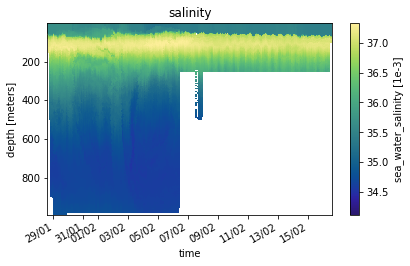

In [ ]:
for i in range(len(to_plot)):
    plotter(ds, to_plot[i], dict[to_plot[i]], to_plot[i])